In [12]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torchinfo
from sklearn.model_selection import train_test_split
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
import torchtext.transforms as T
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
from torch.nn import functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import gensim.downloader
import sys 
sys.path.append('..')
from data.loadData import MovieReviews

In [5]:
# setting hyperparameters
batch_size = 128
valid_size=0.3 # validation + testing
test_size=0.5 # tesing / (testing+validation)
learning_rate = 0.0001
weight_decay = 0.0001
epoch = 20
seed = 42
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

tokenizer = get_tokenizer("basic_english")
glove_vectors = gensim.downloader.load('glove-twitter-25')
unknown_vector = torch.randn(glove_vectors.vector_size)
max_length = 40
embed_dim = 25
label_size = 2
min_frequency = 5
unk_token = '<unk>'
bos_token = '<bos>'
eos_token = '<eos>'
pad_token= '<pad>'
unk_idx = 0
bos_idx = 1
eos_idx = 2
padding_idx = 3

print(torch.__version__)
print(device)

2.1.1+cu121
cuda


In [106]:
# data loading
df = MovieReviews()
train_data, temp_data = train_test_split(df, test_size=valid_size, random_state=seed)
val_data, test_data = train_test_split(temp_data, test_size=test_size, random_state=seed)

In [107]:
vocab = build_vocab_from_iterator(
    train_data["text"].str.split(),
    min_freq=min_frequency,
    specials=[unk_token, eos_token, bos_token, pad_token],
    #  Special symbols to add. The order of supplied tokens will be preserved.
)
vocab.set_default_index(vocab[unk_token])

In [108]:
text_transform = T.Sequential(                  # chaining multiple text transformations
    T.VocabTransform(vocab),                    # convert input batch of tokens into corresponding token ids
    T.Truncate(max_length - 2),                 # Truncate input sequence
    T.AddToken(token=bos_idx, begin=True),      # Add token to beginning or end of sequence
    T.AddToken(token=eos_idx, begin=False),
    T.ToTensor(),                               # Convert input to torch tensor
    T.PadTransform(max_length, padding_idx),    # Pad tensor to a fixed length with given padding value.
)

def collate_fn(batch: np.ndarray):
    text_placeholder, label_placeholder = [], []

    for text, label in batch:
        text = tokenizer(text)
        text = text_transform(text) # shape: [max_len, embed_dim]
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.Tensor(label_placeholder)

In [109]:
# DataLoader
train_iter = DataLoader(
    train_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)
test_iter = DataLoader(
    test_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False           #　don't shuffle to check answer with original data
)
val_iter = DataLoader(
    val_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True
)

In [110]:
vocab_to_index = vocab.get_stoi()
vocab_size = len(vocab_to_index)
embeds = torch.randn(vocab_size, embed_dim)

for word, index in vocab_to_index.items():
    if word in glove_vectors:
        embeds[index] = torch.tensor(glove_vectors[word])

In [112]:
# model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class TransformerClassifier(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        label_size: int,
        num_encoder_layers: int,
        num_attention_heads: int,
        proj_dim: int,
    ):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embeds, freeze=False)
        self.proj = nn.Linear(embed_dim, proj_dim)
        self.pos_encoder = PositionalEncoding(proj_dim, dropout=0.2)
        encoder_layer = TransformerEncoderLayer(proj_dim, num_attention_heads)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_encoder_layers)
        self.fc = nn.Linear(proj_dim, label_size)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Batch_size, Seq_len
        x = self.embedding(x)           # Batch_size, Seq_len, Embed_dim
        x = self.proj(x)                # Batch_size, Seq_len, Proj_dim
        x = self.pos_encoder(x)         # Batch_size, Seq_len, Proj_dim
        x = self.transformer_encoder(x) # Batch_size, Seq_len, Proj_dim
                                        # Take the output from the final encoder layer
        x = x[:, -1, :]                 # Batch_size, Proj_dim
        x = self.dropout(x)             # Batch_size, Proj_dim
        y = self.fc(x)                  # Batch_size, label_size  
        return y

In [113]:
model = TransformerClassifier(embed_dim=embed_dim, label_size=label_size, num_encoder_layers=12, num_attention_heads=16, proj_dim=64).to(device)
print(torchinfo.summary(model))

Layer (type:depth-idx)                                            Param #
TransformerClassifier                                             --
├─Embedding: 1-1                                                  83,050
├─Linear: 1-2                                                     1,664
├─PositionalEncoding: 1-3                                         --
│    └─Dropout: 2-1                                               --
├─TransformerEncoder: 1-4                                         --
│    └─ModuleList: 2-2                                            --
│    │    └─TransformerEncoderLayer: 3-1                          281,152
│    │    └─TransformerEncoderLayer: 3-2                          281,152
│    │    └─TransformerEncoderLayer: 3-3                          281,152
│    │    └─TransformerEncoderLayer: 3-4                          281,152
│    │    └─TransformerEncoderLayer: 3-5                          281,152
│    │    └─TransformerEncoderLayer: 3-6                          

train

In [114]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [115]:
model.train()
training_loss = []
valid_loss = []
training_accuracy = []
valid_accuracy = []

for e in range(epoch):
    correct = 0 # for train_accuracy
    for text, label in tqdm(train_iter):
        optimizer.zero_grad()
        text = text.to(device)
        label = label.to(device)
        output = model(text)
        loss = criterion(output, label.long())
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        preds = torch.argmax(output, dim=1)
        correct += (preds == label).sum().item()
        
    training_accuracy.append(correct / len(train_iter.dataset))
    training_loss.append(loss.item())
    print(f'Epoch [{e+1}/{epoch}], Training_Loss: {loss.item():.4f}')

    # Validation
    num_correct = 0 # for valid_accuracy
    model.eval()
    val_loss = 0.0
    for x, y in val_iter:
        y = y.to(device)
        preds = model(x.to(device))
        loss = criterion(preds, y.long().to(device))
        val_loss += loss.item()
        num_correct += (torch.argmax(preds, dim=1) == y).sum().item()
    
    valid_accuracy.append(num_correct / len(val_iter.dataset))
    val_loss /= len(val_iter)
    valid_loss.append(val_loss)
    print(f'Validation loss: {val_loss:.4f}')

100%|██████████| 58/58 [00:08<00:00,  7.15it/s]


Epoch [1/20], Training_Loss: 0.6772
Validation loss: 0.6935


100%|██████████| 58/58 [00:06<00:00,  8.49it/s]


Epoch [2/20], Training_Loss: 0.6928
Validation loss: 0.6967


100%|██████████| 58/58 [00:06<00:00,  8.45it/s]


Epoch [3/20], Training_Loss: 0.6934
Validation loss: 0.6943


100%|██████████| 58/58 [00:06<00:00,  8.35it/s]


Epoch [4/20], Training_Loss: 0.6890
Validation loss: 0.6944


100%|██████████| 58/58 [00:07<00:00,  7.71it/s]


Epoch [5/20], Training_Loss: 0.6916
Validation loss: 0.6954


100%|██████████| 58/58 [00:07<00:00,  7.77it/s]


Epoch [6/20], Training_Loss: 0.6913
Validation loss: 0.6946


100%|██████████| 58/58 [00:07<00:00,  7.64it/s]


Epoch [7/20], Training_Loss: 0.6937
Validation loss: 0.6932


100%|██████████| 58/58 [00:07<00:00,  7.66it/s]


Epoch [8/20], Training_Loss: 0.6932
Validation loss: 0.6929


100%|██████████| 58/58 [00:07<00:00,  7.58it/s]


Epoch [9/20], Training_Loss: 0.6923
Validation loss: 0.6931


100%|██████████| 58/58 [00:07<00:00,  7.53it/s]


Epoch [10/20], Training_Loss: 0.6907
Validation loss: 0.6931


100%|██████████| 58/58 [00:07<00:00,  7.53it/s]


Epoch [11/20], Training_Loss: 0.6940
Validation loss: 0.6955


100%|██████████| 58/58 [00:07<00:00,  7.57it/s]


Epoch [12/20], Training_Loss: 0.6938
Validation loss: 0.6930


100%|██████████| 58/58 [00:07<00:00,  7.67it/s]


Epoch [13/20], Training_Loss: 0.6938
Validation loss: 0.6930


100%|██████████| 58/58 [00:07<00:00,  7.61it/s]


Epoch [14/20], Training_Loss: 0.6953
Validation loss: 0.6980


100%|██████████| 58/58 [00:07<00:00,  7.65it/s]


Epoch [15/20], Training_Loss: 0.6921
Validation loss: 0.6937


100%|██████████| 58/58 [00:07<00:00,  7.60it/s]


Epoch [16/20], Training_Loss: 0.6931
Validation loss: 0.6929


100%|██████████| 58/58 [00:07<00:00,  7.75it/s]


Epoch [17/20], Training_Loss: 0.6915
Validation loss: 0.6954


100%|██████████| 58/58 [00:07<00:00,  7.75it/s]


Epoch [18/20], Training_Loss: 0.6937
Validation loss: 0.6935


100%|██████████| 58/58 [00:07<00:00,  7.77it/s]


Epoch [19/20], Training_Loss: 0.6948
Validation loss: 0.6959


100%|██████████| 58/58 [00:07<00:00,  7.73it/s]


Epoch [20/20], Training_Loss: 0.6927
Validation loss: 0.6931


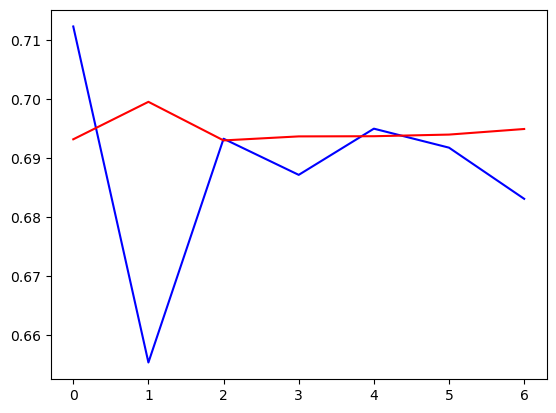

In [96]:
plt.plot(training_loss, 'b', valid_loss, 'r')

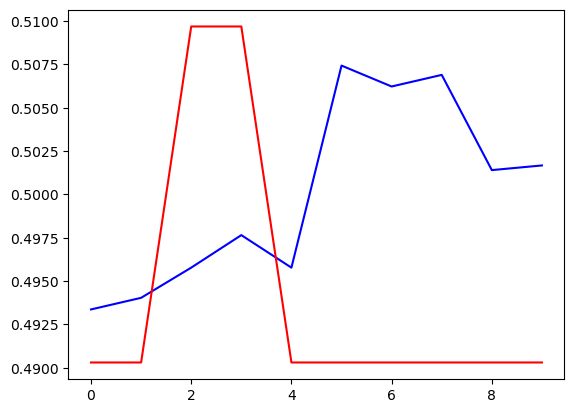

In [97]:
plt.plot(training_accuracy, 'b', valid_accuracy, 'r')

In [116]:
model.eval()
preds = []
labels = []
with torch.no_grad():
    running_hit = 0.0

    for text, label in tqdm(test_iter):
        text = text.to(device)
        label = label.to(device)

        output = model(text)
        pred = output.argmax(dim=1)
        labels.append(label)
        preds.append(pred)
    preds_cat = torch.cat(preds).to('cpu')
    labels_cat = torch.cat(labels).to('cpu')
    
    accuracy = accuracy_score(preds_cat, labels_cat)
    precision = precision_score(preds_cat, labels_cat)
    recall = recall_score(preds_cat, labels_cat)
    f1 = f1_score(preds_cat, labels_cat)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print(f'Test Precision: {precision * 100:.2f}%')
    print(f'Test Recall: {recall * 100:.2f}%')
    print(f'Test F1 Score: {f1 * 100:.2f}%')

100%|██████████| 13/13 [00:00<00:00, 21.08it/s]

Test Accuracy: 50.00%
Test Precision: 100.00%
Test Recall: 50.00%
Test F1 Score: 66.67%


In [94]:
# Save the model if needed
# torch.save(model.state_dict(), 'TextCNN.pth')

In [95]:
# Instantiate the model
# model = TextCNN(vocab_size, 32, label_size, padding_idx=padding_idx)

# Load the saved state dictionary
# model_path = 'TextCNN.pth'
# model_state_dict = torch.load(model_path)

# Load the state dictionary into the model
# model.load_state_dict(model_state_dict)